# Week 1 Challenge Project Template

You are not required to use this template, but we are providing it for your reference to help get you started and stay organized!  We recommend that you define functions for each step to make it easier to track what's going on in the code (especially if different team members are working on different pieces of the project).

Most of the functions provided are just examples!  Feel free to replace them with something better!  This is just a minimum working example.

## 1. Load the data

In [74]:
!pip install tflearn
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
import keras
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score
from sklearn import grid_search
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

%matplotlib inline

In [52]:
train_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.train.data.csv"
test_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.test.data.csv"

data_train = pd.read_csv(train_url) 
data_test = pd.read_csv(test_url)   # this will not have a 'class' column!

# identify columns by what time of data they hold
numeric_columns=list(["Age","TSH","T3","TT4","T4u","FTI"])

# categorical columns are everything else (minus 'class')
categorical_columns = list(set(data_train.columns)-set(numeric_columns)-set(['class']))
data_train.head()


,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,TBG measured,TBG,referral source,class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative.|3733
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative.|1442
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative.|2965
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative.|806
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative.|2807


## 2. Format your class labels
Turn multi-classes into binary classes

In [0]:
def format_class_labels(df):
    
    import re 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

      
        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', row['class'])
        df.loc[index,'class']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['class'] = df['class'].replace('negative', 0)                    
    df['class'] = df['class'].replace('compensated hypothyroid', 1)     
    df['class'] = df['class'].replace('primary hypothyroid', 1)         
    df['class'] = df['class'].replace('secondary hypothyroid', 1)
    
    return df

data_train = format_class_labels(data_train)

## 3. Split training into training and validation
Choose what split you like (alternatively, you can do k-fold cross validation)

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data_train, test_size=0.20, random_state=0, stratify=data_train['class'])

## 4. Clean/format the data
Note: removing rows is probably a bad idea because you won't be able to do this to the test data!  Try to come up with some clever ways to handle the "?" values.

In [0]:
# change all ?s to -1
def handle_questions(df):
    df.replace('?',0, inplace=True)
    return df


# Make sure you do the same thing to train & val so the data is all formatted the same
data_train = handle_questions(data_train)
data_val = handle_questions(data_val)

In [0]:
def get_uninformative_columns(df):
    
    drop_columns = []
    
    for col in df.columns:
        
        # if this column has only one value, we can't learn anything from it
        if(len(df[col].unique()) == 1):
            drop_columns.append(col)
            
    return drop_columns


# drop the uninformative features
drop_columns = get_uninformative_columns(data_train)

# Make sure you do the same thing to train & val
data_train=data_train.drop(drop_columns,axis=1)
data_val=data_val.drop(drop_columns,axis=1)

In [89]:
def format_data(df, numeric_columns):

    # convert numeric columns from strings to numbers
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)    

    categorical_columns = list(set(df.columns)-set(numeric_columns))

    # convert categorical columns to indicator (0,1) variables
    for col in categorical_columns:
        
        try:
            df[col] = pd.get_dummies(df[col],drop_first=True)
        except Exception as e:
            print(e)

    return df



# Make sure you do the same thing to train & val
data_train = format_data(data_train, numeric_columns)
data_val = format_data(data_val, numeric_columns)

data_train.corr()['class']

Age                         -0.013257
Sex                          0.030444
On thyroxine                -0.086678
query on thyroxine          -0.019589
on antithyroid medication   -0.030389
sick                         0.017049
pregnant                    -0.036790
thyroid surgery             -0.006188
I131 treatment               0.027244
query hypothyroid            0.064723
query hyperthyroid          -0.035534
lithium                     -0.000468
goitre                      -0.027009
tumor                        0.017003
psych                       -0.012063
TSH measured                 0.096126
TSH                          0.474426
T3 measured                  0.015392
T3                          -0.105303
TT4 measured                 0.053398
TT4                         -0.192397
T4U measured                 0.020304
T4u                          0.031125
FTI measured                 0.020304
FTI                         -0.194450
referral source             -0.058624
class       

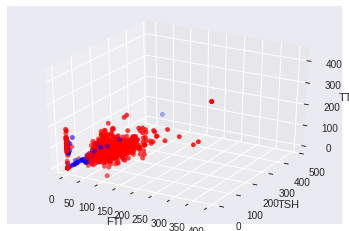

In [90]:


# Fit Support Vector Machine Classifier

f1 = 'FTI'
f2 = 'TSH'
f3 = 'TT4'

colors = {0:'red', 1:'blue'}


threedee = plt.figure().gca(projection='3d')
threedee.scatter(data_train[f1], data_train[f2], data_train[f3], c=data_train['class'].apply(lambda x: colors[x]))
threedee.set_xlabel(f1)
threedee.set_ylabel(f2)
threedee.set_zlabel(f3)
plt.show()


## 5. Define and Train the Model
You might want to consider having one process for training on one dataset and evaluating on another.  That way you can use the same code for your train/validation as you do for your train/test

In [0]:
def my_classifier_predictions(data_train, data_predict):

    feature_columns = list(set(data_train.columns)-set(['class']))

    X_train = data_train[feature_columns]
    y_train = data_train['class']
    
    X_val = data_predict[feature_columns]
    
    estimators = []

    model1 = RandomForestClassifier(n_estimators=10, random_state=0)
    estimators.append(('rf', model1))
    model2 = svm.SVC(kernel='rbf', C=10, decision_function_shape='ovo', gamma=1e-05, probability=True)
    estimators.append(('svm', model2))
    # create the ensemble model
    lr_model = VotingClassifier(estimators, voting='soft')
    
    
    '''# For now, we'll just do logistic regression
    estimators = []

    model1 = RandomForestClassifier(n_estimators=10, random_state=0)
    estimators.append(('rf', model1))
    model2 = svm.SVC(kernel='rbf', C=10, decision_function_shape='ovo', gamma=1e-05, probability=True)
    estimators.append(('svm', model2))
    # create the ensemble model
    lr_model = VotingClassifier(estimators, voting='soft')'''

    # fit the model to training data 
    lr_model.fit(X_train, y_train)

    # apply the model to evaluation data
    y_proba = lr_model.predict_proba(X_val)
    
    return y_proba

In [0]:
# Predict on validation data
y_val_proba = my_classifier_predictions(data_train, data_val)

## 6. Evaluate your model

### Confusion Matrix Metric

Function for Score Computation

In [0]:
def score(cm_matrix):
  x = cm_matrix.item(0) -(12.5*cm_matrix.item(1))-(12.5*cm_matrix.item(2)) + cm_matrix.item(3)
  print("Score is", x)
  


In [45]:
from sklearn.metrics import confusion_matrix

# evaluate on validation set
y_val = data_val['class']

# This is exctly the first metric you'll be evaluated on!
# Note: this will only work on the binary case -- let us know if you get to the multi-class case

def cm_metric(y_true,y_prob):
    
    # predict the class with the greatest probability
    y_val_predict = [np.argmax(y) for y in y_prob]

    # calculate the confusion matrix
    cm = confusion_matrix(y_true, y_val_predict)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_norm)
    score(cm_norm)
    return sum(sum(np.multiply(cm_norm,np.array([[1, -2], [-2, 1]]))))
#sum(sum(np.multiply(cm_norm,np.array([[1, -2], [-2, 1]]))))
print('Confusion Matrix Metric: ',cm_metric(y_val,y_val_proba))

#
#print(cm_norm)



[[0.99418605 0.00581395]
 [0.22727273 0.77272727]]
Score is -1.1466701902748413
Confusion Matrix Metric:  1.3007399577167018


Function for score computation

### AUC

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(y_val, y_val_proba[:,1])
roc_auc = auc(fpr, tpr)
print('AUC: ',roc_auc)



AUC:  0.9979739252995067


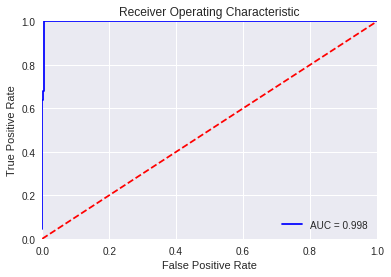

In [47]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 7. Apply to test data
Once you're happy with your model, you should go through the same procedure again except:
* train with ALL the training data (re-combine with training and validation)
* test on test data (you won't be able to evaluate -- that's for us to do!)

In [0]:
train_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.train.data.csv"
test_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.test.data.csv"

data_train = pd.read_csv(train_url) 
data_test = pd.read_csv(test_url)   # this will not have a 'class' column!

# format the wonky class labels
data_train = format_class_labels(data_train)

# deal with question marks
data_train = handle_questions(data_train)
data_test = handle_questions(data_test)

# drop uninformative columns
drop_columns = get_uninformative_columns(data_train)
data_train=data_train.drop(drop_columns,axis=1)
data_test=data_test.drop(drop_columns,axis=1)

# format data
data_train = format_data(data_train, numeric_columns)
data_test = format_data(data_test, numeric_columns)

# train and apply your classifier
y_test_proba = my_classifier_predictions(data_train, data_test)

## 8. Submit your attempt!

Once you've run on the test data, send a pickle file containing your predictions contained a pandas dataframe.  This pandas dataframe will contain two columns for your binary classifier (or 4 columns for the multiclass classifier) that looks like this (*pay attention to the column names!*):

|   | 0 | 1   |
|---|---|------|
| 0 | $p_{0,0}$ | $p_{0,1}$|
| 1 | $p_{1,0}$ | $p_{1,1}$|
| 2 | $p_{2,0}$ | $p_{2,1}$|
| ... | ... | ...|
| N | $p_{N,0}$ | $p_{N,1}$|

where $p_{i,j}$ corresponds to the probability of data point $i$ belonging to class $j$.

In [0]:
from google.colab import files
import pickle

# create a pickle file (this will save to the Google cloud)
prediction_pickle_path = 'teamname_week1_attempt1.pkl'
prediction_pickle = open(prediction_pickle_path, 'wb')
pickle.dump(y_test_proba, prediction_pickle)

# download the pickle file and save it somewhere to your computer, and email it to 
files.download(prediction_pickle_path)
prediction_pickle.close()

# Moving to the Next Level

For those that finish early, remember how I converted the class values into simply "negative" and "positive"? Now try tackling the multiclass classifier (predicting the different types of positive hypothyroid cases instead of simply negative or positive)! 

The same rules apply!  (Note: for the multiclass problem, the AUC calculation will be the micro-average over your classes.)

(And for those that also finish the multiclass classifer, see Lyle for further instructions).